# Convolutional Neural Network

In [373]:
import torch
import torchvision
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn, optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split

In [374]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model

In [375]:
class CNN(nn.Module):
    def __init__(self, layers: list[nn.Module]):
        super().__init__()
        self.history = []
        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)

        return x
    
    def summary(self, input_shape, batch_size):
        summary(self, input_shape, batch_size)

    def config(self, loss: nn.Module, optimizer: optim.Optimizer):
        if not isinstance(loss, nn.Module):
            raise TypeError("loss must be a torch.nn.Module instance")
        if not isinstance(optimizer, optim.Optimizer):
            raise TypeError("optimizer must be a torch.optim.Optimizer instance")
        
        self.criterion = loss
        self.optimizer = optimizer

    def fit(self, train_loader: DataLoader, epochs: int = 10, verbose: bool = True):
        for epoch in range(epochs):
            self.train()

            # Split the train set into train and validation set
            train_set, val_set = random_split(train_loader.dataset, [50000, 10000])
            train_set = DataLoader(train_set, batch_size=64, shuffle=True)
            val_set = DataLoader(val_set, batch_size=64, shuffle=True)

            loss_list = []

            for images, labels in tqdm(train_set, desc=f"Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)

                self.optimizer.zero_grad()
                
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                loss_list.append(loss.item())

                loss.backward()
                self.optimizer.step()

            with torch.no_grad():
                self.eval()

                total = 0
                accuracy = 0
                val_loss = []

                for images, labels in val_set:
                    images, labels = images.to(device), labels.to(device)

                    outputs = self(images)
                    total += labels.size(0)
                    predicted = torch.argmax(outputs, dim=1)

                    accuracy += (predicted == labels).sum().item()
                    val_loss.append(self.criterion(outputs, labels).item())

                # Calculate the mean loss and accuracy
                mean_val_loss = sum(val_loss) / len(val_loss)
                mean_val_acc = 100 * (accuracy / total)
                loss = sum(loss_list) / len(loss_list)
                self.history.append((loss, mean_val_loss, mean_val_acc))

                if verbose:
                    print(
                        f"Loss: {loss:.4f}, Val Loss: {mean_val_loss:.4f}, Val Accuracy: {mean_val_acc:.2f}%"
                    )

        return self.history

    def predict(self, x):
        predicted = []

        with torch.no_grad():
            self.eval()
            for images, _ in x:
                images = images.to(device)

                outputs = self(images)
                predicted.append(torch.argmax(outputs, 1))

        return predicted

## Cook

### Data preprocessing

In [376]:
preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [377]:
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=preprocess
)
test_set = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=preprocess
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

### Training

In [378]:
model = CNN(
    [
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Flatten(),
        nn.Linear(64 * 14 * 14, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.Softmax(dim=1),
    ]
).to(device)

model.summary(train_loader.dataset[0][0].shape, 64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 28, 28]             320
              ReLU-2           [64, 32, 28, 28]               0
            Conv2d-3           [64, 64, 28, 28]          18,496
              ReLU-4           [64, 64, 28, 28]               0
         MaxPool2d-5           [64, 64, 14, 14]               0
           Flatten-6                [64, 12544]               0
            Linear-7                  [64, 128]       1,605,760
              ReLU-8                  [64, 128]               0
            Linear-9                   [64, 10]           1,290
          Softmax-10                   [64, 10]               0
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 85.88
Params size (MB): 6.20
Estima

In [379]:
model.config(nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001))

In [380]:
history = model.fit(train_loader, epochs=10)

Epoch 1/10: 100%|██████████| 782/782 [00:05<00:00, 143.15it/s]


Loss: 1.6267, Val Loss: 1.5804, Val Accuracy: 88.09%


Epoch 2/10: 100%|██████████| 782/782 [00:05<00:00, 142.97it/s]


Loss: 1.5799, Val Loss: 1.5790, Val Accuracy: 88.18%


Epoch 3/10: 100%|██████████| 782/782 [00:05<00:00, 141.16it/s]


Loss: 1.5031, Val Loss: 1.4791, Val Accuracy: 98.21%


Epoch 4/10: 100%|██████████| 782/782 [00:05<00:00, 141.47it/s]


Loss: 1.4769, Val Loss: 1.4814, Val Accuracy: 98.03%


Epoch 5/10: 100%|██████████| 782/782 [00:05<00:00, 138.34it/s]


Loss: 1.4756, Val Loss: 1.4740, Val Accuracy: 98.71%


Epoch 6/10: 100%|██████████| 782/782 [00:05<00:00, 132.02it/s]


Loss: 1.4732, Val Loss: 1.4732, Val Accuracy: 98.82%


Epoch 7/10: 100%|██████████| 782/782 [00:05<00:00, 141.56it/s]


Loss: 1.4734, Val Loss: 1.4753, Val Accuracy: 98.61%


Epoch 8/10: 100%|██████████| 782/782 [00:05<00:00, 138.65it/s]


Loss: 1.4723, Val Loss: 1.4718, Val Accuracy: 98.93%


Epoch 9/10: 100%|██████████| 782/782 [00:05<00:00, 142.62it/s]


Loss: 1.4714, Val Loss: 1.4699, Val Accuracy: 99.10%


Epoch 10/10: 100%|██████████| 782/782 [00:05<00:00, 147.85it/s]


Loss: 1.4715, Val Loss: 1.4710, Val Accuracy: 99.01%


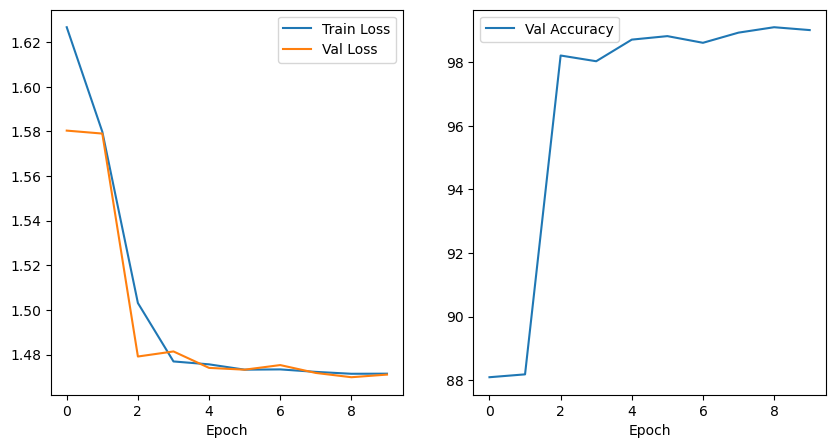

In [381]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in history], label="Train Loss")
plt.plot([x[1] for x in history], label="Val Loss")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x[2] for x in history], label="Val Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Test model

In [382]:
x = [images for images, _ in test_loader]
y_true = [labels for _, labels in test_loader]
y_pred = model.predict(test_loader)

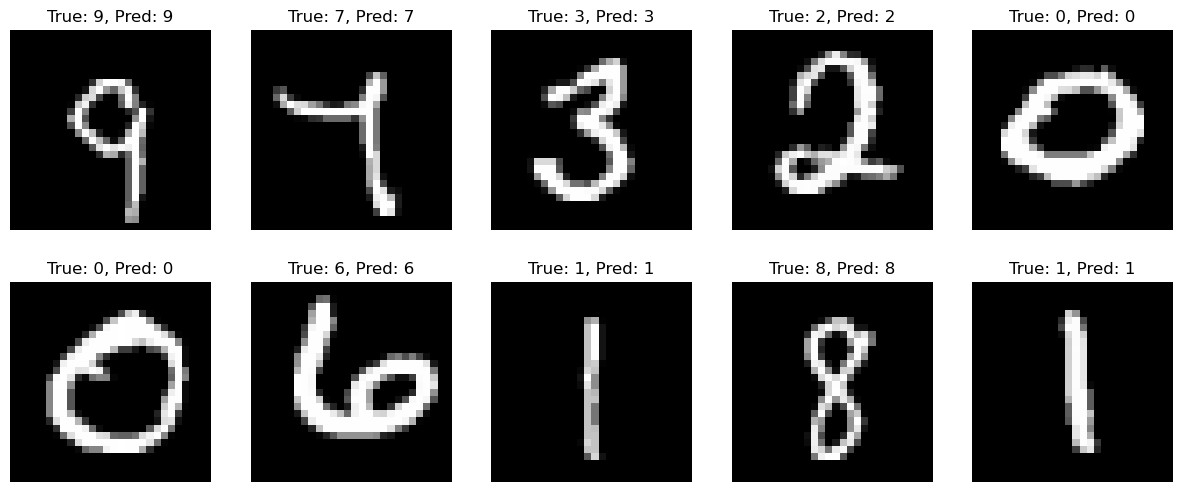

In [383]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    random_idx = torch.randint(0, 64, (1, 2)).squeeze()
    axs[i // 5, i % 5].imshow(x[random_idx[0]][random_idx[1]].squeeze(), cmap="gray")
    axs[i // 5, i % 5].set_title(
        f"True: {y_true[random_idx[0]][random_idx[1]]}, Pred: {y_pred[random_idx[0]][random_idx[1]]}"
    )
    axs[i // 5, i % 5].axis("off")

plt.show()